In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tqdm.notebook import tqdm
from keras.utils import to_categorical
import gensim
import numpy as np
from keras.callbacks import callbacks
from sentence_transformers import SentenceTransformer

Using TensorFlow backend.


In [2]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:
#aravec
t_model = gensim.models.Word2Vec.load(
    '../downloads/aravec/full_uni_cbow_100_twitter/full_uni_cbow_100_twitter.mdl')

In [3]:
train_df = pd.read_csv('../NADI-2020_release_1.0/NADI_release/train_labeled.tsv',sep='\t')
dev_df = pd.read_csv('../NADI-2020_release_1.0/NADI_release/dev_labeled.tsv',sep='\t')

X_train_original,y_train_original = train_df["#2 tweet_content"],train_df["#3 country_label"]
X_dev_original,y_dev_original = dev_df["#2 tweet_content"],dev_df["#3 country_label"]

In [4]:
labels = {}
uni = y_train_original.unique()
for i in range(len(uni)):
    labels[uni[i]] = i

y_train_index = [labels[i] for i in y_train_original]
y_dev_index = [labels[i] for i in y_dev_original]

y_train = to_categorical(y_train_index, num_classes=21)
y_dev = to_categorical(y_dev_index, num_classes=21)

In [7]:
X_noov = []
for sentence in X_train_original:
    sentence = sentence.split(' ')
    new_sentence = []
    for word in sentence:
        if word in t_model.wv.vocab:
            new_sentence.append(word)
    X_noov.append(new_sentence)
X_noov_dev = []
for sentence in X_dev_original:
    sentence = sentence.split(' ')
    new_sentence = []
    for word in sentence:
        if word in t_model.wv.vocab:
            new_sentence.append(word)
    X_noov_dev.append(new_sentence)

In [11]:
X_train = []
counter = 0
for one_vec in X_noov:
    if one_vec == []:
        counter += 1
        one_vec = ['ومايشوف']
    word_vector = t_model.wv[ one_vec ]
#     word_vector = np.sum(word_vector,axis=0)
    word_vector = np.pad(word_vector,pad_width=((0,100-word_vector.shape[0]),(0,0)))
    X_train.append(word_vector)

X_dev = []
counter = 0
for one_vec in X_noov_dev:
    if one_vec == []:
        counter += 1
        one_vec = ['ومايشوف']
    word_vector = t_model.wv[ one_vec ]
#     word_vector = np.sum(word_vector,axis=0)
    word_vector = np.pad(word_vector,pad_width=((0,100-word_vector.shape[0]),(0,0)))
    X_dev.append(word_vector)

In [ ]:
X_train = np.array(X_train)
X_dev = np.array(X_dev)

In [ ]:
X_train.shape

In [8]:
model = Sequential()
model.add(LSTM(10, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
model.add(LSTM(10, dropout=0.2, recurrent_dropout=0.2,return_sequences=False))
# model.add(Dense(512, activation='relu'))
model.add(Dense(21, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
history = model.fit(X_train,y_train,epochs=200,validation_data=(X_dev,y_dev),
                   callbacks=[callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)])

NameError: name 'X_train' is not defined

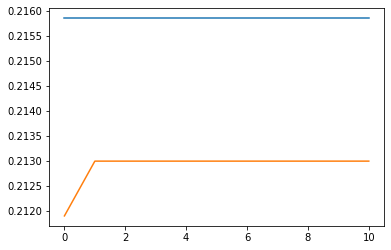

In [12]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.show()

In [13]:
X_train = []
counter = 0
for one_vec in X_noov:
    if one_vec == []:
        counter += 1
        one_vec = ['ومايشوف']
    word_vector = t_model.wv[ one_vec ]
    word_vector = np.sum(word_vector,axis=0)
#     word_vector = np.pad(word_vector,pad_width=((0,100-word_vector.shape[0]),(0,0)))
    X_train.append(word_vector)

X_dev = []
counter = 0
for one_vec in X_noov_dev:
    if one_vec == []:
        counter += 1
        one_vec = ['ومايشوف']
    word_vector = t_model.wv[ one_vec ]
    word_vector = np.sum(word_vector,axis=0)
#     word_vector = np.pad(word_vector,pad_width=((0,100-word_vector.shape[0]),(0,0)))
    X_dev.append(word_vector)

In [14]:
X_train = np.array(X_train)
X_dev = np.array(X_dev)

In [15]:
X_train.shape

(21000, 100)

In [16]:
model = Sequential()
# model.add(LSTM(10, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
# model.add(LSTM(10, dropout=0.2, recurrent_dropout=0.2,return_sequences=False))
model.add(Dense(512, activation='relu'))
model.add(Dense(21, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
history = model.fit(X_train,y_train,epochs=200,validation_data=(X_dev,y_dev),
                   callbacks=[callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)])

Train on 21000 samples, validate on 4957 samples
Epoch 1/200
21000/21000 [==============================] - 1s 57us/step - loss: 3.4226 - accuracy: 0.2509 - val_loss: 2.6937 - val_accuracy: 0.2857
Epoch 2/200
21000/21000 [==============================] - 1s 48us/step - loss: 2.3935 - accuracy: 0.3243 - val_loss: 2.5883 - val_accuracy: 0.3000
Epoch 3/200
21000/21000 [==============================] - 1s 49us/step - loss: 2.2147 - accuracy: 0.3562 - val_loss: 2.5878 - val_accuracy: 0.3048
Epoch 4/200
21000/21000 [==============================] - 1s 49us/step - loss: 2.1042 - accuracy: 0.3798 - val_loss: 2.6184 - val_accuracy: 0.2996
Epoch 5/200
21000/21000 [==============================] - 1s 49us/step - loss: 2.0200 - accuracy: 0.3985 - val_loss: 2.6800 - val_accuracy: 0.2951
Epoch 6/200
21000/21000 [==============================] - 1s 49us/step - loss: 1.9504 - accuracy: 0.4192 - val_loss: 2.7176 - val_accuracy: 0.3002
Epoch 7/200
21000/21000 [==============================] - 1s 5

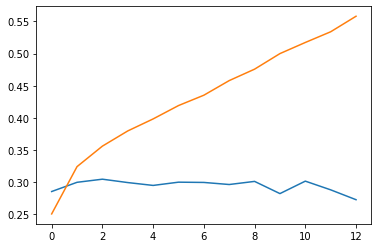

In [18]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.show()

In [5]:
#bert - multilingual
model = SentenceTransformer('distiluse-base-multilingual-cased')

RuntimeError: CUDA out of memory. Tried to allocate 352.00 MiB (GPU 0; 1.96 GiB total capacity; 0 bytes already allocated; 272.75 MiB free; 0 bytes reserved in total by PyTorch)

In [ ]:
X_train = model.encode(X_train_original,show_progress_bar=True,batch_size=512)

In [13]:
X_train = np.array(X_train)

In [6]:
X_dev = model.encode(X_dev_original,show_progress_bar=True,batch_size=512)

Batches: 100%|██████████| 10/10 [03:49<00:00, 22.99s/it]


In [14]:
X_dev = np.array(X_dev)

In [15]:
model = Sequential()
# model.add(LSTM(10, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
# model.add(LSTM(10, dropout=0.2, recurrent_dropout=0.2,return_sequences=False))
model.add(Dense(512, activation='relu'))
model.add(Dense(21, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
history = model.fit(X_train,y_train,epochs=200,validation_data=(X_dev,y_dev),
                   callbacks=[callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)])

Train on 21000 samples, validate on 4957 samples
Epoch 1/200
21000/21000 [==============================] - 3s 128us/step - loss: 2.5095 - accuracy: 0.2609 - val_loss: 2.4338 - val_accuracy: 0.2895
Epoch 2/200
21000/21000 [==============================] - 2s 108us/step - loss: 2.3233 - accuracy: 0.3080 - val_loss: 2.4278 - val_accuracy: 0.2921
Epoch 3/200
21000/21000 [==============================] - 2s 108us/step - loss: 2.2321 - accuracy: 0.3331 - val_loss: 2.4180 - val_accuracy: 0.2988
Epoch 4/200
21000/21000 [==============================] - 2s 109us/step - loss: 2.1537 - accuracy: 0.3539 - val_loss: 2.4292 - val_accuracy: 0.2986
Epoch 5/200
21000/21000 [==============================] - 2s 111us/step - loss: 2.0788 - accuracy: 0.3732 - val_loss: 2.4447 - val_accuracy: 0.3036
Epoch 6/200
21000/21000 [==============================] - 2s 113us/step - loss: 2.0018 - accuracy: 0.3940 - val_loss: 2.4725 - val_accuracy: 0.2925
Epoch 7/200
21000/21000 [==============================] 

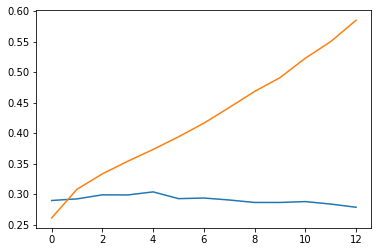

In [17]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.show()

In [5]:
#fasttext-arabic
from tqdm import tqdm_notebook
from nltk import word_tokenize
from pymagnitude import *


glove = Magnitude("../downloads/fasttext-arabic/fasttext-arabic.magnitude")
def avg_glove(x):
    vectors = []
    for title in tqdm_notebook(x):
        vectors.append(np.average(glove.query(word_tokenize(title)), axis = 0))
    return np.array(vectors)

X_train = avg_glove(X_train_original)
y_train = y_train_original
X_dev = avg_glove(X_dev_original)
y_dev = y_dev_original

/home/nikamanth/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [6]:
labels = {}
uni = y_train_original.unique()
for i in range(len(uni)):
    labels[uni[i]] = i

y_train_index = [labels[i] for i in y_train_original]
y_dev_index = [labels[i] for i in y_dev_original]

y_train = to_categorical(y_train_index, num_classes=21)
y_dev = to_categorical(y_dev_index, num_classes=21)

In [26]:
model = Sequential()
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2,return_sequences=False))
model.add(Dense(512, activation='relu'))
model.add(Dense(21, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',f1_m])
history = model.fit(X_train,y_train,epochs=30,validation_data=(X_dev,y_dev),
                   callbacks=[callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)])

Train on 21000 samples, validate on 4957 samples
Epoch 1/30
21000/21000 [==============================] - 2s 89us/step - loss: 2.3516 - accuracy: 0.3145 - f1_m: 0.1779 - val_loss: 2.2077 - val_accuracy: 0.3708 - val_f1_m: 0.2308
Epoch 2/30
21000/21000 [==============================] - 2s 76us/step - loss: 2.1271 - accuracy: 0.3747 - f1_m: 0.2563 - val_loss: 2.1480 - val_accuracy: 0.3881 - val_f1_m: 0.2685
Epoch 3/30
21000/21000 [==============================] - 2s 76us/step - loss: 2.0499 - accuracy: 0.3961 - f1_m: 0.2758 - val_loss: 2.1504 - val_accuracy: 0.3928 - val_f1_m: 0.2868
Epoch 4/30
21000/21000 [==============================] - 2s 83us/step - loss: 1.9965 - accuracy: 0.4083 - f1_m: 0.2915 - val_loss: 2.1337 - val_accuracy: 0.3964 - val_f1_m: 0.2844
Epoch 5/30
21000/21000 [==============================] - 2s 91us/step - loss: 1.9537 - accuracy: 0.4232 - f1_m: 0.3057 - val_loss: 2.1368 - val_accuracy: 0.3982 - val_f1_m: 0.2975
Epoch 6/30
21000/21000 [======================

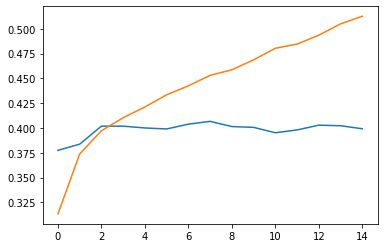

In [8]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.show()

In [14]:
pred = model.predict_classes(X_dev)

In [17]:
reverse_label_map = {value : key for (key, value) in labels.items()}

In [20]:
li = [reverse_label_map[i] for i in pred]

In [21]:
with open('../tsv/keras_res.txt','wt') as file:
    for i in li:
        file.write(i+'\n')

In [23]:
dev_df['#3 country_label']

0          Iraq
1         Egypt
2       Algeria
3         Yemen
4         Egypt
         ...   
4952    Tunisia
4953      Egypt
4954      Egypt
4955      Egypt
4956      Qatar
Name: #3 country_label, Length: 4957, dtype: object